In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_context(context='notebook',font_scale=1.3)
%matplotlib inline
import pandas as pd
import sqlite3 as sq
import scipy as sp
import sklearn as sk
#f = '/Users/jeffreychapple/Documents/myskedmproject/skedm-master/skedm'
#sys.path.append(f)

In [2]:
import skedm as edm
import buoypy.buoypy as bp

In [3]:
buoy = 41110
year = 2014

H = bp.historic_data(41110,year)

In [4]:
X = H.get_stand_meteo()

In [5]:
X.head()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
2014-03-14 17:40:00,NaN,NaN,NaN,0.53,9.88,5.98,96.0,NaN,NaN,10.5,NaN,NaN,NaN
2014-03-14 18:10:00,NaN,NaN,NaN,0.54,9.88,5.91,NaN,NaN,NaN,10.6,NaN,NaN,NaN
2014-03-14 18:40:00,NaN,NaN,NaN,0.53,10.53,5.85,102.0,NaN,NaN,10.7,NaN,NaN,NaN
2014-03-14 19:10:00,NaN,NaN,NaN,0.55,9.88,6.04,95.0,NaN,NaN,10.8,NaN,NaN,NaN
2014-03-14 19:40:00,NaN,NaN,NaN,0.57,10.53,6.29,NaN,NaN,NaN,10.7,NaN,NaN,NaN


In [6]:
X.tail();

In [7]:
X.describe();

In [8]:
w = pd.DataFrame(X.WVHT) #extracting jut the wave height
p = pd.DataFrame(X.DPD)  #extracting just the period
wd = pd.DataFrame(X.MWD) #extracting just wind direction
ap = pd.DataFrame(X.APD) #"              "average period
wt = pd.DataFrame(X.WTMP) #"              "water temp

In [9]:
len(w), len(p), len(wd), len(ap), len(wt)


(13680, 13680, 13680, 13680, 13680)

In [10]:
p.head(); #just to look at the data

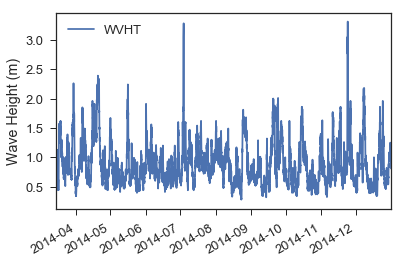

In [11]:
w.plot()
plt.ylabel('Wave Height (m)')

In [12]:
w.head()

,WVHT
2014-03-14 17:40:00,0.53
2014-03-14 18:10:00,0.54
2014-03-14 18:40:00,0.53
2014-03-14 19:10:00,0.55
2014-03-14 19:40:00,0.57


# cast data into array values

In [13]:
w_array = w.values.astype(float) #extracting just the values of Wave data
w_array.size,w_array.shape

(13680, (13680, 1))

In [14]:
ww = w.resample('D').mean() #resampled the data-> daily avg
ww.size,ww.shape

(293, (293, 1))

In [15]:
ww.head()

,WVHT
2014-03-14,0.552308
2014-03-15,0.783542
2014-03-16,0.592083
2014-03-17,1.348542
2014-03-18,1.414043


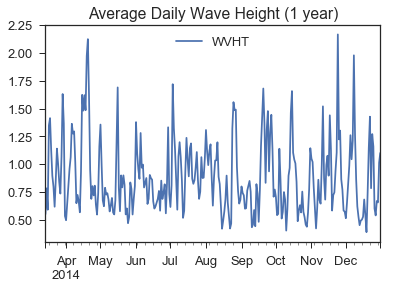

In [16]:
ww.plot(title='Average Daily Wave Height (1 year)')

# No shifting or Lag

In [17]:
ww.head()

,WVHT
2014-03-14,0.552308
2014-03-15,0.783542
2014-03-16,0.592083
2014-03-17,1.348542
2014-03-18,1.414043


In [18]:
ww.dropna().head()

,WVHT
2014-03-14,0.552308
2014-03-15,0.783542
2014-03-16,0.592083
2014-03-17,1.348542
2014-03-18,1.414043


In [19]:
ww['wvht_targets'] = ww['WVHT'].shift(-1) # setting targets and new dataframe

In [20]:
ww.head()

,WVHT,wvht_targets
2014-03-14,0.552308,0.783542
2014-03-15,0.783542,0.592083
2014-03-16,0.592083,1.348542
2014-03-17,1.348542,1.414043
2014-03-18,1.414043,1.126875


In [21]:
ww.dropna(inplace=True)

In [22]:
ww.head()

,WVHT,wvht_targets
2014-03-14,0.552308,0.783542
2014-03-15,0.783542,0.592083
2014-03-16,0.592083,1.348542
2014-03-17,1.348542,1.414043
2014-03-18,1.414043,1.126875


In [23]:
ww.columns

Index(['WVHT', 'wvht_targets'], dtype='object')

In [24]:
ww_array = ww.values.astype(float) #extracting resampled values of Wave data

x=ww[['WVHT',]]
#x = ww[['WVHT','wvht_shift1','wvht_shift2']].values #here used three different lags 
y = ww['wvht_targets'].values.reshape(-1,1) 

a = int(len(x)*0.67) #training size

trainx = x[:a]
testx = x[a:]

trainy = y[:a]
testy = y[a:]

from sklearn import linear_model
   
# Create Linear regression object
regr = linear_model.LinearRegression()

#train the model using training sets
regr.fit(trainx,trainy)

#Coefficients
print('coefficients: \n', regr.coef_)

# MSE (mean squared error)
print("Mean squared error: %.2f" 
      % np.mean((regr.predict(testx)-testy)**2))

#Explained variance score:  1 is perfect prediction
print ('Variance score: %.2f' % regr.score(testx, testy))


trainPredict = regr.predict(trainx) #plugging x into y = mx+b
testPredict = regr.predict(testx)


coefficients: 
 [[ 0.63648146]]
Mean squared error: 0.08
Variance score: 0.32


In [25]:
trainx.shape,trainy.shape,testx.shape,testy.shape

((195, 1), (195, 1), (97, 1), (97, 1))

In [26]:
LRcd_0 = 1-np.sum((testPredict-testy)**2)/np.sum((testy-np.mean(testy))**2) #coefficient of Det.
LRcd_0

0.32476782517081015

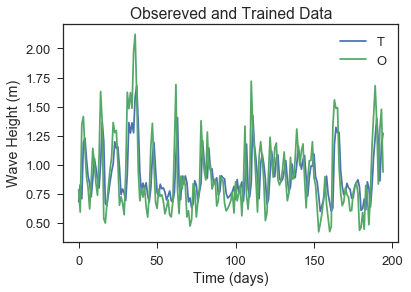

In [27]:
plt.plot(trainPredict)
plt.plot(trainy)
plt.title('Obsereved and Trained Data')
plt.xlabel('Time (days)')
plt.ylabel('Wave Height (m)')
plt.legend('TO')

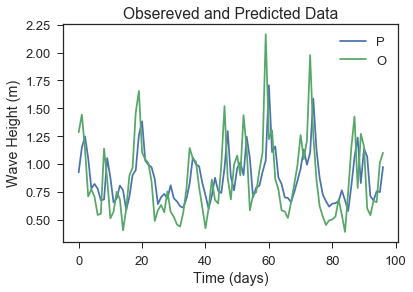

In [28]:
plt.plot(testPredict)
plt.plot(testy)
plt.title('Obsereved and Predicted Data')
plt.xlabel('Time (days)')
plt.ylabel('Wave Height (m)')
plt.legend('PO')

In [29]:
dates = pd.DataFrame(pd.to_datetime(ww.reset_index()['index']))
dates.rename(columns={'index':''},inplace=True)

In [30]:
trX = np.empty((len(y),1))
trX[:a] = trainPredict
trX[a:] = np.nan

tstX = np.empty((len(y),1))
tstX[:a] = np.nan
tstX[a:] = testPredict

df = dates
df['targets'] = y
df['trainX'] = trX
df['tstX'] = tstX

df.set_index('', inplace=True)

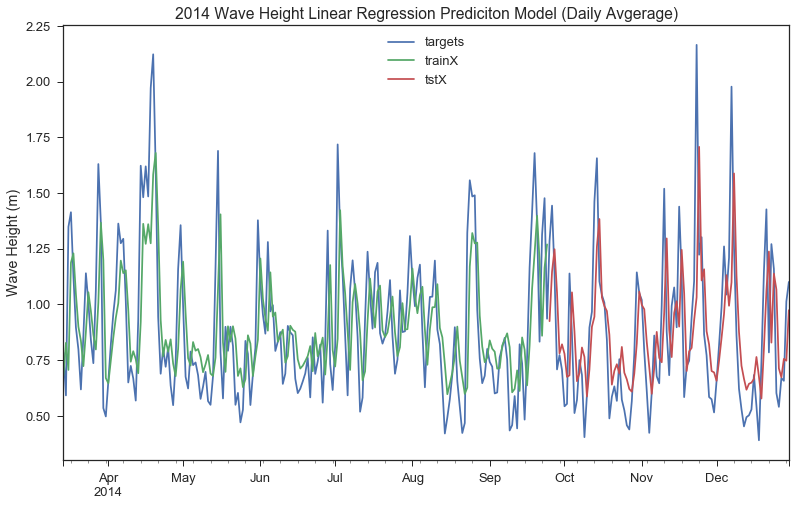

In [31]:
df.plot(figsize=(13,8))
plt.title('2014 Wave Height Linear Regression Prediciton Model (Daily Avgerage)')
plt.ylabel('Wave Height (m)')

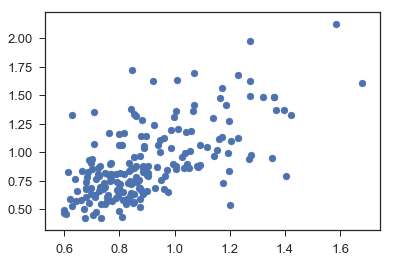

In [32]:
plt.scatter(trainPredict,trainy)

# 1 Shift (lag)

In [33]:
ww = w.resample('D').mean() #resampled the data-> daily avg

In [34]:
ww.head()

,WVHT
2014-03-14,0.552308
2014-03-15,0.783542
2014-03-16,0.592083
2014-03-17,1.348542
2014-03-18,1.414043


In [35]:
ww['wvht_shift1'] = ww['WVHT'].shift(1) 

In [36]:
ww.head()

,WVHT,wvht_shift1
2014-03-14,0.552308,NaN
2014-03-15,0.783542,0.552308
2014-03-16,0.592083,0.783542
2014-03-17,1.348542,0.592083
2014-03-18,1.414043,1.348542


In [37]:
ww.dropna().head() #getting rid of any NaN's

,WVHT,wvht_shift1
2014-03-15,0.783542,0.552308
2014-03-16,0.592083,0.783542
2014-03-17,1.348542,0.592083
2014-03-18,1.414043,1.348542
2014-03-19,1.126875,1.414043


In [38]:
ww['wvht_targets'] = ww['WVHT'].shift(-1) # setting targets and new dataframe

In [39]:
ww.head()

,WVHT,wvht_shift1,wvht_targets
2014-03-14,0.552308,NaN,0.783542
2014-03-15,0.783542,0.552308,0.592083
2014-03-16,0.592083,0.783542,1.348542
2014-03-17,1.348542,0.592083,1.414043
2014-03-18,1.414043,1.348542,1.126875


In [40]:
ww.dropna(inplace=True)

In [41]:
ww.head()

,WVHT,wvht_shift1,wvht_targets
2014-03-15,0.783542,0.552308,0.592083
2014-03-16,0.592083,0.783542,1.348542
2014-03-17,1.348542,0.592083,1.414043
2014-03-18,1.414043,1.348542,1.126875
2014-03-19,1.126875,1.414043,0.896667


In [42]:
ww.columns

Index(['WVHT', 'wvht_shift1', 'wvht_targets'], dtype='object')

In [43]:
ww_array = ww.values.astype(float) #extracting resampled values of Wave data

x=ww[['WVHT','wvht_shift1']]
#x = ww[['WVHT','wvht_shift1','wvht_shift2']].values #here used three different lags 
y = ww['wvht_targets'].values.reshape(-1,1) 

a = int(len(x)*0.67) #training size

trainx = x[:a]
testx = x[a:]

trainy = y[:a]
testy = y[a:]

from sklearn import linear_model
   
# Create Linear regression object
regr = linear_model.LinearRegression()

#train the model using training sets
regr.fit(trainx,trainy)

#Coefficients
print('coefficients: \n', regr.coef_)

# MSE (mean squared error)
print("Mean squared error: %.2f" 
      % np.mean((regr.predict(testx)-testy)**2))

#Explained variance score:  1 is perfect prediction
print ('Variance score: %.2f' % regr.score(testx, testy))


trainPredict = regr.predict(trainx) #plugging x into y = mx+b
testPredict = regr.predict(testx)


coefficients: 
 [[ 0.82749176 -0.2959254 ]]
Mean squared error: 0.08
Variance score: 0.30


In [44]:
LRcd_1 = 1-np.sum((testPredict-testy)**2)/np.sum((testy-np.mean(testy))**2) #coefficient of Det.
LRcd_1

0.30045285028762858

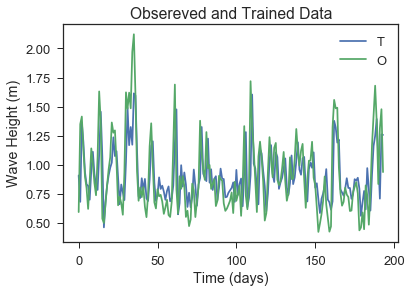

In [45]:
plt.plot(trainPredict)
plt.plot(trainy)
plt.title('Obsereved and Trained Data')
plt.xlabel('Time (days)')
plt.ylabel('Wave Height (m)')
plt.legend('TO')

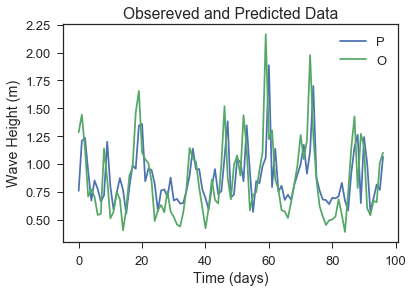

In [46]:
plt.plot(testPredict)
plt.plot(testy)
plt.title('Obsereved and Predicted Data')
plt.xlabel('Time (days)')
plt.ylabel('Wave Height (m)')
plt.legend('PO')

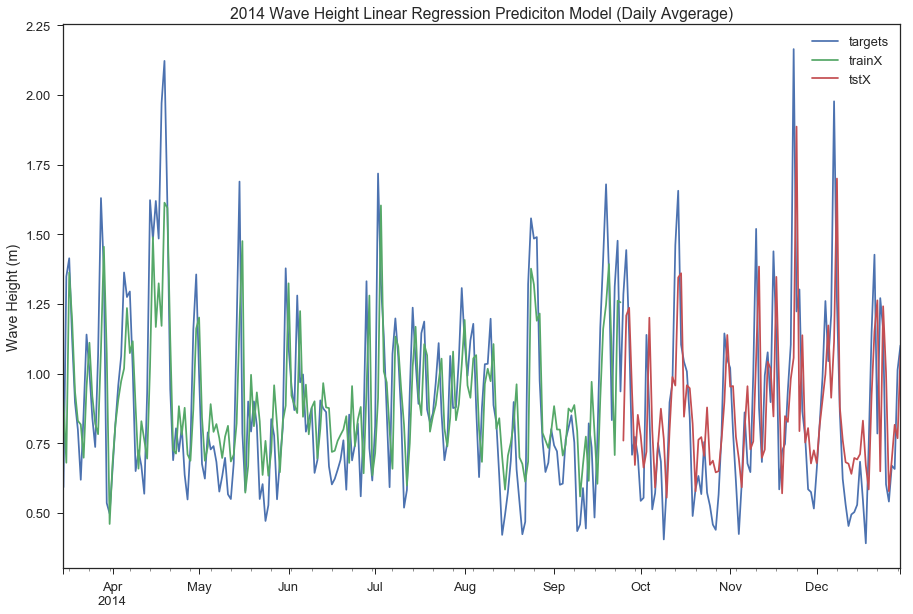

In [47]:
dates = pd.DataFrame(pd.to_datetime(ww.reset_index()['index']))
dates.rename(columns={'index':''},inplace=True)

trX = np.empty((len(y),1))
trX[:a] = trainPredict
trX[a:] = np.nan

tstX = np.empty((len(y),1))
tstX[:a] = np.nan
tstX[a:] = testPredict

df = dates
df['targets'] = y
df['trainX'] = trX
df['tstX'] = tstX

df.set_index('', inplace=True)

df.plot(figsize=(15,10))
plt.title('2014 Wave Height Linear Regression Prediciton Model (Daily Avgerage)')
plt.ylabel('Wave Height (m)')

# 2 shifts

In [48]:
ww = w.resample('D').mean() #resampled the data-> daily avg

In [49]:
ww.head()

,WVHT
2014-03-14,0.552308
2014-03-15,0.783542
2014-03-16,0.592083
2014-03-17,1.348542
2014-03-18,1.414043


In [50]:
ww['wvht_shift1'] = ww['WVHT'].shift(1)  
ww['wvht_shift2'] = ww['WVHT'].shift(2)

In [51]:
ww.head()

,WVHT,wvht_shift1,wvht_shift2
2014-03-14,0.552308,NaN,NaN
2014-03-15,0.783542,0.552308,NaN
2014-03-16,0.592083,0.783542,0.552308
2014-03-17,1.348542,0.592083,0.783542
2014-03-18,1.414043,1.348542,0.592083


In [52]:
ww.dropna().head() #getting rid of any NaN's

,WVHT,wvht_shift1,wvht_shift2
2014-03-16,0.592083,0.783542,0.552308
2014-03-17,1.348542,0.592083,0.783542
2014-03-18,1.414043,1.348542,0.592083
2014-03-19,1.126875,1.414043,1.348542
2014-03-20,0.896667,1.126875,1.414043


In [53]:
ww['wvht_targets'] = ww['WVHT'].shift(-1) # setting targets and new dataframe

In [54]:
ww.head()

,WVHT,wvht_shift1,wvht_shift2,wvht_targets
2014-03-14,0.552308,NaN,NaN,0.783542
2014-03-15,0.783542,0.552308,NaN,0.592083
2014-03-16,0.592083,0.783542,0.552308,1.348542
2014-03-17,1.348542,0.592083,0.783542,1.414043
2014-03-18,1.414043,1.348542,0.592083,1.126875


In [55]:
ww.dropna(inplace=True)

In [56]:
ww.head()

,WVHT,wvht_shift1,wvht_shift2,wvht_targets
2014-03-16,0.592083,0.783542,0.552308,1.348542
2014-03-17,1.348542,0.592083,0.783542,1.414043
2014-03-18,1.414043,1.348542,0.592083,1.126875
2014-03-19,1.126875,1.414043,1.348542,0.896667
2014-03-20,0.896667,1.126875,1.414043,0.798298


In [57]:
ww_array = ww.values.astype(float) #extracting resampled values of Wave data


x = ww[['WVHT','wvht_shift1','wvht_shift2']].values #here used three different lags 
y = ww['wvht_targets'].values.reshape(-1,1) 

a = int(len(x)*0.67) #training size

trainx = x[:a]
testx = x[a:]

trainy = y[:a]
testy = y[a:]

from sklearn import linear_model
   
# Create Linear regression object
regr = linear_model.LinearRegression()

#train the model using training sets
regr.fit(trainx,trainy)

#Coefficients
print('coefficients: \n', regr.coef_)

# MSE (mean squared error)
print("Mean squared error: %.2f" 
      % np.mean((regr.predict(testx)-testy)**2))

#Explained variance score:  1 is perfect prediction
print ('Variance score: %.2f' % regr.score(testx, testy))


trainPredict = regr.predict(trainx) #plugging x into y = mx+b
testPredict = regr.predict(testx)


coefficients: 
 [[ 0.8471084  -0.36863813  0.10912805]]
Mean squared error: 0.08
Variance score: 0.30


In [58]:
LRcd_2 = 1-np.sum((testPredict-testy)**2)/np.sum((testy-np.mean(testy))**2) #coefficient of Det.
LRcd_2

0.30302359419063685

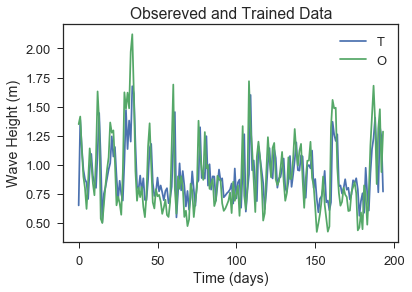

In [59]:
plt.plot(trainPredict)
plt.plot(trainy)
plt.title('Obsereved and Trained Data')
plt.xlabel('Time (days)')
plt.ylabel('Wave Height (m)')
plt.legend('TO')

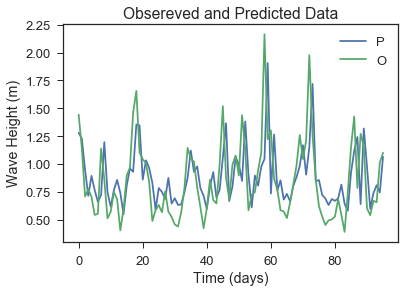

In [60]:
plt.plot(testPredict)
plt.plot(testy)
plt.title('Obsereved and Predicted Data')
plt.xlabel('Time (days)')
plt.ylabel('Wave Height (m)')
plt.legend('PO')

In [61]:
dates = pd.DataFrame(pd.to_datetime(ww.reset_index()['index']))
dates.rename(columns={'index':''},inplace=True)

In [62]:
trX = np.empty((len(y),1))
trX[:a] = trainPredict
trX[a:] = np.nan

tstX = np.empty((len(y),1))
tstX[:a] = np.nan
tstX[a:] = testPredict

df = dates
df['targets'] = y
df['trainX'] = trX
df['tstX'] = tstX

df.set_index('', inplace=True)

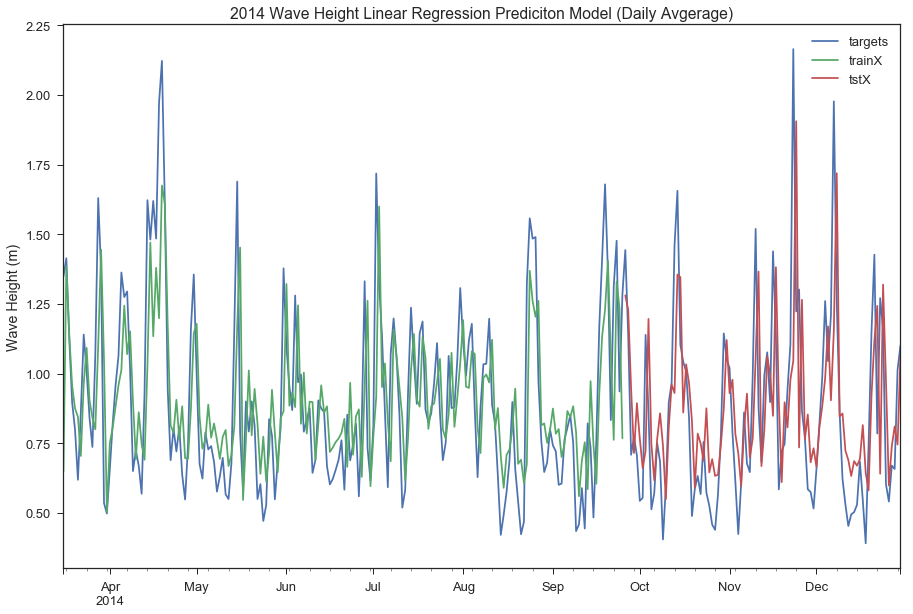

In [63]:
df.plot(figsize=(15,10))
plt.title('2014 Wave Height Linear Regression Prediciton Model (Daily Avgerage)')
plt.ylabel('Wave Height (m)')

# 3 shifts

In [64]:
ww = w.resample('D').mean() #resampled the data-> daily avg

In [65]:
ww.head()

,WVHT
2014-03-14,0.552308
2014-03-15,0.783542
2014-03-16,0.592083
2014-03-17,1.348542
2014-03-18,1.414043


In [66]:
ww['wvht_shift1'] = ww['WVHT'].shift(1)  
ww['wvht_shift2'] = ww['WVHT'].shift(2)
ww['wvht_shift3'] = ww['WVHT'].shift(3)


In [67]:
ww.head()

,WVHT,wvht_shift1,wvht_shift2,wvht_shift3
2014-03-14,0.552308,NaN,NaN,NaN
2014-03-15,0.783542,0.552308,NaN,NaN
2014-03-16,0.592083,0.783542,0.552308,NaN
2014-03-17,1.348542,0.592083,0.783542,0.552308
2014-03-18,1.414043,1.348542,0.592083,0.783542


In [68]:
ww.dropna().head()

,WVHT,wvht_shift1,wvht_shift2,wvht_shift3
2014-03-17,1.348542,0.592083,0.783542,0.552308
2014-03-18,1.414043,1.348542,0.592083,0.783542
2014-03-19,1.126875,1.414043,1.348542,0.592083
2014-03-20,0.896667,1.126875,1.414043,1.348542
2014-03-21,0.798298,0.896667,1.126875,1.414043


In [69]:
ww['wvht_targets'] = ww['WVHT'].shift(-1) # setting targets and new dataframe

In [70]:
ww.head()

,WVHT,wvht_shift1,wvht_shift2,wvht_shift3,wvht_targets
2014-03-14,0.552308,NaN,NaN,NaN,0.783542
2014-03-15,0.783542,0.552308,NaN,NaN,0.592083
2014-03-16,0.592083,0.783542,0.552308,NaN,1.348542
2014-03-17,1.348542,0.592083,0.783542,0.552308,1.414043
2014-03-18,1.414043,1.348542,0.592083,0.783542,1.126875


In [71]:
ww.dropna(inplace=True)

In [72]:
ww.head()

,WVHT,wvht_shift1,wvht_shift2,wvht_shift3,wvht_targets
2014-03-17,1.348542,0.592083,0.783542,0.552308,1.414043
2014-03-18,1.414043,1.348542,0.592083,0.783542,1.126875
2014-03-19,1.126875,1.414043,1.348542,0.592083,0.896667
2014-03-20,0.896667,1.126875,1.414043,1.348542,0.798298
2014-03-21,0.798298,0.896667,1.126875,1.414043,0.618936


In [73]:
ww_array = ww.values.astype(float) #extracting resampled values of Wave data


x = ww[['WVHT','wvht_shift1','wvht_shift2','wvht_shift3']].values #here used three different lags 
y = ww['wvht_targets'].values.reshape(-1,1) 

a = int(len(x)*0.67) #training size

trainx = x[:a]
testx = x[a:]

trainy = y[:a]
testy = y[a:]

from sklearn import linear_model
   
# Create Linear regression object
regr = linear_model.LinearRegression()

#train the model using training sets
regr.fit(trainx,trainy)

#Coefficients
print('coefficients: \n', regr.coef_)

# MSE (mean squared error)
print("Mean squared error: %.2f" 
      % np.mean((regr.predict(testx)-testy)**2))

#Explained variance score:  1 is perfect prediction
print ('Variance score: %.2f' % regr.score(testx, testy))


trainPredict = regr.predict(trainx) #plugging x into y = mx+b
testPredict = regr.predict(testx)


coefficients: 
 [[  8.67814123e-01  -3.91873104e-01   1.31117116e-01   8.67444415e-04]]
Mean squared error: 0.08
Variance score: 0.30


In [74]:
LRcd_3 = 1-np.sum((testPredict-testy)**2)/np.sum((testy-np.mean(testy))**2) #coefficient of Det.
LRcd_3

0.2961536342559361

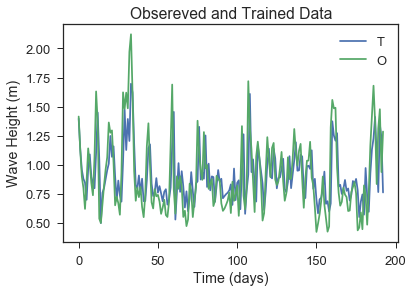

In [75]:
plt.plot(trainPredict)
plt.plot(trainy)
plt.title('Obsereved and Trained Data')
plt.xlabel('Time (days)')
plt.ylabel('Wave Height (m)')
plt.legend('TO')

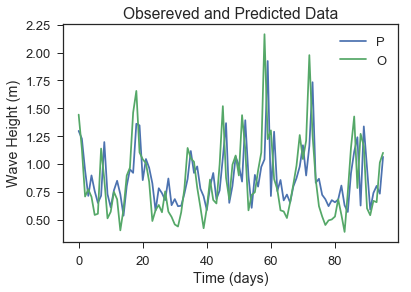

In [76]:
plt.plot(testPredict)
plt.plot(testy)
plt.title('Obsereved and Predicted Data')
plt.xlabel('Time (days)')
plt.ylabel('Wave Height (m)')
plt.legend('PO')

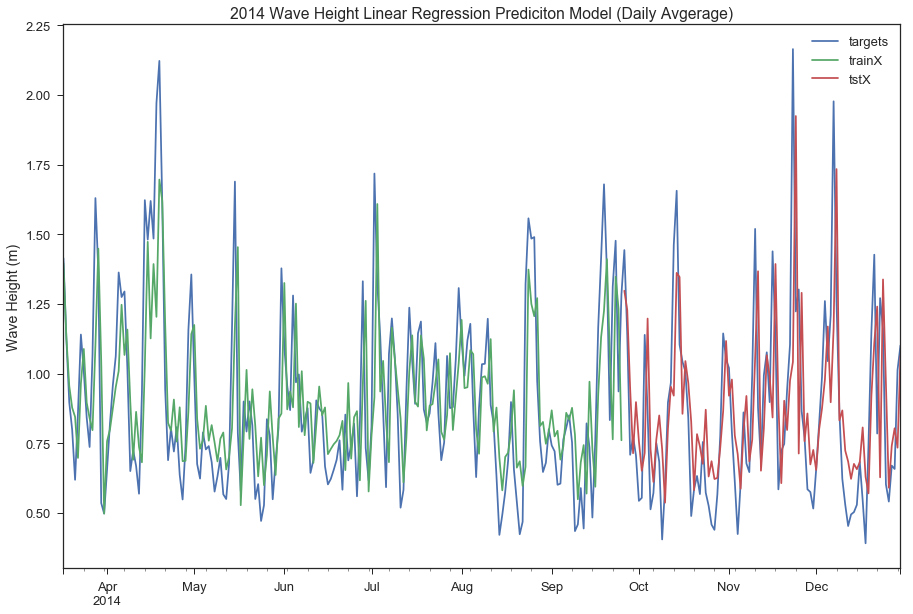

In [77]:
dates = pd.DataFrame(pd.to_datetime(ww.reset_index()['index']))
dates.rename(columns={'index':''},inplace=True)

trX = np.empty((len(y),1))
trX[:a] = trainPredict
trX[a:] = np.nan

tstX = np.empty((len(y),1))
tstX[:a] = np.nan
tstX[a:] = testPredict

df = dates
df['targets'] = y
df['trainX'] = trX
df['tstX'] = tstX

df.set_index('', inplace=True)

df.plot(figsize=(15,10))
plt.title('2014 Wave Height Linear Regression Prediciton Model (Daily Avgerage)')
plt.ylabel('Wave Height (m)')

# 4 shifts

In [78]:
ww = w.resample('D').mean() #resampled the data-> daily avg

In [79]:
ww.head()

,WVHT
2014-03-14,0.552308
2014-03-15,0.783542
2014-03-16,0.592083
2014-03-17,1.348542
2014-03-18,1.414043


In [80]:
ww['wvht_shift1'] = ww['WVHT'].shift(1)  
ww['wvht_shift2'] = ww['WVHT'].shift(2)
ww['wvht_shift3'] = ww['WVHT'].shift(3)
ww['wvht_shift4'] = ww['WVHT'].shift(4)

In [81]:
ww.head()

,WVHT,wvht_shift1,wvht_shift2,wvht_shift3,wvht_shift4
2014-03-14,0.552308,NaN,NaN,NaN,NaN
2014-03-15,0.783542,0.552308,NaN,NaN,NaN
2014-03-16,0.592083,0.783542,0.552308,NaN,NaN
2014-03-17,1.348542,0.592083,0.783542,0.552308,NaN
2014-03-18,1.414043,1.348542,0.592083,0.783542,0.552308


In [82]:
ww.dropna().head()

,WVHT,wvht_shift1,wvht_shift2,wvht_shift3,wvht_shift4
2014-03-18,1.414043,1.348542,0.592083,0.783542,0.552308
2014-03-19,1.126875,1.414043,1.348542,0.592083,0.783542
2014-03-20,0.896667,1.126875,1.414043,1.348542,0.592083
2014-03-21,0.798298,0.896667,1.126875,1.414043,1.348542
2014-03-22,0.618936,0.798298,0.896667,1.126875,1.414043


In [83]:
ww['wvht_targets'] = ww['WVHT'].shift(-1) # setting targets and new dataframe

In [84]:
ww.head()

,WVHT,wvht_shift1,wvht_shift2,wvht_shift3,wvht_shift4,wvht_targets
2014-03-14,0.552308,NaN,NaN,NaN,NaN,0.783542
2014-03-15,0.783542,0.552308,NaN,NaN,NaN,0.592083
2014-03-16,0.592083,0.783542,0.552308,NaN,NaN,1.348542
2014-03-17,1.348542,0.592083,0.783542,0.552308,NaN,1.414043
2014-03-18,1.414043,1.348542,0.592083,0.783542,0.552308,1.126875


In [85]:
ww.dropna(inplace=True)

In [86]:
ww.head()

,WVHT,wvht_shift1,wvht_shift2,wvht_shift3,wvht_shift4,wvht_targets
2014-03-18,1.414043,1.348542,0.592083,0.783542,0.552308,1.126875
2014-03-19,1.126875,1.414043,1.348542,0.592083,0.783542,0.896667
2014-03-20,0.896667,1.126875,1.414043,1.348542,0.592083,0.798298
2014-03-21,0.798298,0.896667,1.126875,1.414043,1.348542,0.618936
2014-03-22,0.618936,0.798298,0.896667,1.126875,1.414043,0.860652


In [87]:
ww_array = ww.values.astype(float) #extracting resampled values of Wave data

x=ww[['WVHT','wvht_shift1']]
#x = ww[['WVHT','wvht_shift1','wvht_shift2']].values #here used three different lags 
y = ww['wvht_targets'].values.reshape(-1,1) 

a = int(len(x)*0.67) #training size

trainx = x[:a]
testx = x[a:]

trainy = y[:a]
testy = y[a:]

from sklearn import linear_model
   
# Create Linear regression object
regr = linear_model.LinearRegression()

#train the model using training sets
regr.fit(trainx,trainy)

#Coefficients
print('coefficients: \n', regr.coef_)

# MSE (mean squared error)
print("Mean squared error: %.2f" 
      % np.mean((regr.predict(testx)-testy)**2))

#Explained variance score:  1 is perfect prediction
print ('Variance score: %.2f' % regr.score(testx, testy))


trainPredict = regr.predict(trainx) #plugging x into y = mx+b
testPredict = regr.predict(testx)


coefficients: 
 [[ 0.82567327 -0.28032926]]
Mean squared error: 0.08
Variance score: 0.32


In [88]:
LRcd_4 = 1-np.sum((testPredict-testy)**2)/np.sum((testy-np.mean(testy))**2) #coefficient of Det.
LRcd_4

0.31582463711419062

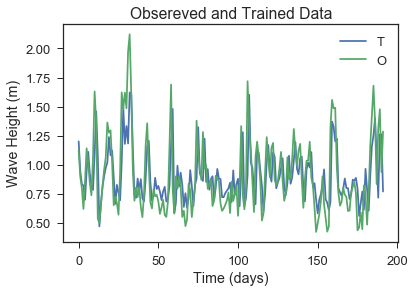

In [89]:
plt.plot(trainPredict)
plt.plot(trainy)
plt.title('Obsereved and Trained Data')
plt.xlabel('Time (days)')
plt.ylabel('Wave Height (m)')
plt.legend('TO')

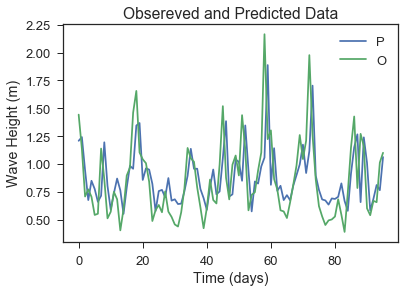

In [90]:
plt.plot(testPredict)
plt.plot(testy)
plt.title('Obsereved and Predicted Data')
plt.xlabel('Time (days)')
plt.ylabel('Wave Height (m)')
plt.legend('PO')

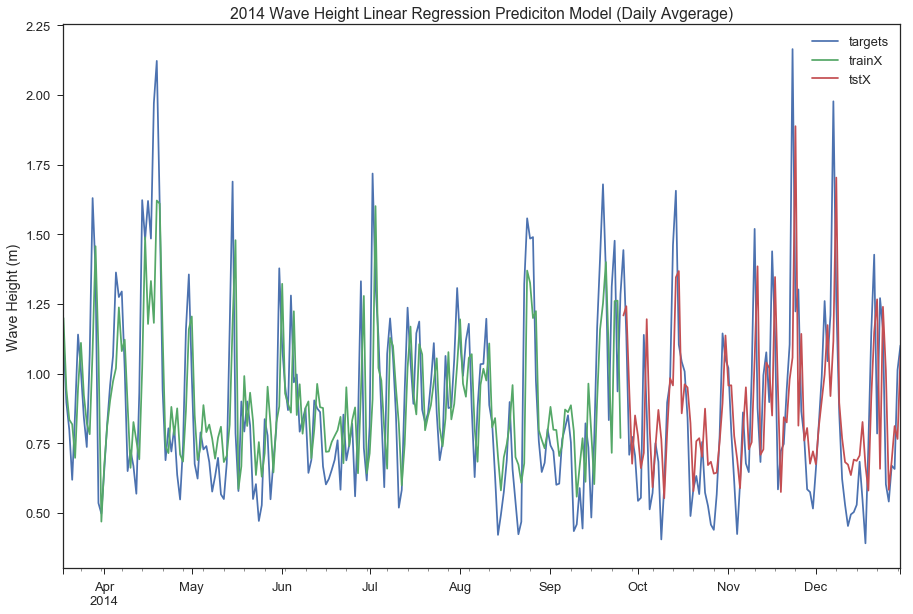

In [91]:
dates = pd.DataFrame(pd.to_datetime(ww.reset_index()['index']))
dates.rename(columns={'index':''},inplace=True)

trX = np.empty((len(y),1))
trX[:a] = trainPredict
trX[a:] = np.nan

tstX = np.empty((len(y),1))
tstX[:a] = np.nan
tstX[a:] = testPredict

df = dates
df['targets'] = y
df['trainX'] = trX
df['tstX'] = tstX

df.set_index('', inplace=True)

df.plot(figsize=(15,10))
plt.title('2014 Wave Height Linear Regression Prediciton Model (Daily Avgerage)')
plt.ylabel('Wave Height (m)')

In [92]:
LRcd_array = [LRcd_0,LRcd_1,LRcd_2,LRcd_3,LRcd_4]
Lags = [0,1,2,3,4]

LRcd_array,Lags

([0.32476782517081015,
  0.30045285028762858,
  0.30302359419063685,
  0.2961536342559361,
  0.31582463711419062],
 [0, 1, 2, 3, 4])

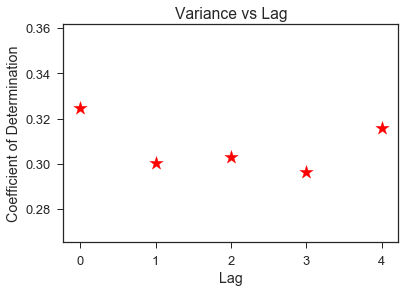

In [93]:
plt.scatter(Lags,LRcd_array,marker='*',c='r',s=200)
plt.xlabel('Lag')
plt.ylabel('Coefficient of Determination')
plt.title('Variance vs Lag')